### Homework 2: Uncertainty and Vision
CS-229 Spring 2023

The goal of this assignment is to get familiar with training a computer vision task (Segmentation) with PyTorch, and to measure confidence calibration in your system. 

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models.segmentation import fcn_resnet50
from torchvision.models.segmentation import deeplabv3_resnet50
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [20]:
class ToIntTensor(transforms.ToTensor):
    """A custom transform that replaces "ToTensor". ToTensor always converts to a 
    a float in range [0,1]. This one converts to an integer, which can represent
    our class labels per pixel in an image segmentation problem"""
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = (tensor * 255).to(torch.int64)
        return tensor

def get_voc_dataloader(batch_size=4):
    """Get the VOC 2007 segmentation dataset and return PyTorch 
    dataloaders for both training and validation. 
    """
    # TODO: 2 points. Define image transforms for both the input image AND the "label" image.
    # Remember, the labels are one category (integer) per pixel. So, while the image_transform
    # normalize the values to have mean zero and unit standard deviation, you shouldn't 
    # do that with the labels, which have to be integers. I provided a "ToIntTensor" transform
    # above to use for the label transform, instead of ToTensor which always turns images to floats. 
    # Also, we want to resize/crop images to be all the same size, a power of 2, and 
    # we should transform the label and image in the same way when changing size.
    # The size of images will drastically impact memory usage - I suggest targeting 128 x 128 
    # or even 64 x 64 if memory constraints are an issue. 
    image_transforms = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128), transforms.ToTensor(),
        transforms.Normalize(mean=[0,0,0], std=[1,1,1])])
    label_transforms = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128), ToIntTensor()])
    # This downloads the data automatically and creates a "dataset" object that applies the transforms
    data_dir = "./Downloads/"  # TODO: Specify path to save data
    train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True, transform=image_transforms, target_transform=label_transforms)
    val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True, transform=image_transforms, target_transform=label_transforms)

    # Create data loaders for the datasets - necessary for efficient training
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl

In [21]:
def train_epoch(model, train_dl, val_dl, optimizer, device):
    """
    Train one epoch of model with optimizer, using data from train_dl.
    Do training on "device". 
    Return the train and validation loss and validation accuracy.
    """
    # We'll use the cross entropy loss. There's a nice feature that it
    # allows you to "ignore_index". In this case index 255 is the mask to ignore
    criterion = nn.CrossEntropyLoss(ignore_index=255)  # recommend to use in constructing loss

    # TODO: Train (3 points)
    # Iterate over the train dataloader
    # Put data batch on same device as model
    # "Forward pass" - run data through model, and use output to calculate loss. 
    # "backward pass"
    # Remember to keep track of training loss during loop. 
    model.train()  #set to train
    train_loss = 0
    for x,y in train_dl:
        x= x.to(device)
        y=y.squeeze(1).to(device)
        optimizer.zero_grad()
        y_hat = model(x)["out"]
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()    
    # TODO: Validation loss and accuracy (2 points)
    # estimate the loss on the validation dataset
    # The network should be in "eval" mode (remember to go back to train mode for training)
    # Turn off grad tracking for speed 
    # Accuracy on validation datais very helpful to output - 
    # 69 percent of pixels are "background" - we hope to get better accuracy than that!
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for x, y in val_dl:
            x=x.to(device)
            y=y.squeeze(1).to(device)
            y_hat= model(x)["out"]
            loss= criterion(y_hat, y)
            val_loss+= loss.item()
            _, ypred= torch.max(y_hat.data, 1)
            correct+= (ypred == y).sum().item()
            total+= (y != 255).sum().item()
    train_loss /=len(train_dl) #normalize
    val_loss /=len(val_dl)
    accuracy = correct/total
    return train_loss, val_loss, accuracy       

### Main loop

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# Define some hyperparameters
batch_size = 64  # Adjust batch size to make maximal use of GPU without running out of memory 
epochs = 50
learning_rate = 0.01
n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored

# Load model and data
model = fcn_resnet50(n_class=n_class).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)
# Training loop
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.)

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss, val_loss, accuracy = train_epoch(model, train_dl, val_dl, optimizer, device)
    
    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy))

Using downloaded and verified file: ./Downloads/VOCtrainval_06-Nov-2007.tar
Extracting ./Downloads/VOCtrainval_06-Nov-2007.tar to ./Downloads/
Using downloaded and verified file: ./Downloads/VOCtrainval_06-Nov-2007.tar
Extracting ./Downloads/VOCtrainval_06-Nov-2007.tar to ./Downloads/
Epoch 1: Train loss: 2.464 | Val loss: 2.462 | Acc: 0.516
Epoch 2: Train loss: 1.005 | Val loss: 1.208 | Acc: 0.734
Epoch 3: Train loss: 0.931 | Val loss: 1.214 | Acc: 0.702
Epoch 4: Train loss: 0.690 | Val loss: 0.921 | Acc: 0.771
Epoch 5: Train loss: 0.546 | Val loss: 0.981 | Acc: 0.751
Epoch 6: Train loss: 0.462 | Val loss: 1.123 | Acc: 0.732
Epoch 7: Train loss: 0.405 | Val loss: 0.882 | Acc: 0.771
Epoch 8: Train loss: 0.349 | Val loss: 0.806 | Acc: 0.788
Epoch 9: Train loss: 0.328 | Val loss: 0.812 | Acc: 0.789
Epoch 10: Train loss: 0.340 | Val loss: 0.812 | Acc: 0.789
Epoch 11: Train loss: 0.277 | Val loss: 0.758 | Acc: 0.793
Epoch 12: Train loss: 0.252 | Val loss: 0.743 | Acc: 0.798
Epoch 13: Train

## Post training visualization and analysis

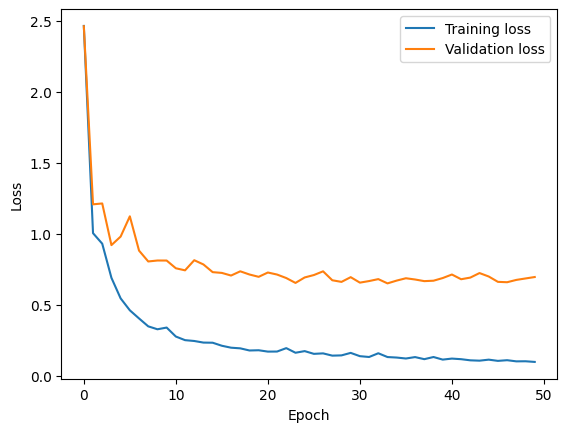

In [23]:
# TODO: Train and test loss plot
# TODO: Print out an example image, true segmentation, and predicted segmentation
# 1 point
# Use a colormap to get good visualizations of the segmentation classes
# cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors
# cmap(numpy class array) outputs something with nice colors
plt.plot(range(len(train_losses)), train_losses, label="Training loss")
plt.plot(range(len(train_losses)), val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
img = Image.open(train_dl.dataset.images[0])
image_transforms = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128), transforms.ToTensor(),
        transforms.Normalize(mean=[0,0,0], std=[1,1,1])])
label_transforms = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128)])
with torch.no_grad():
    imtf= image_transforms(img).unsqueeze(0).to(device)
    pred = model(imtf)
    pred = pred["out"].max(1)[1].cpu().numpy()
gt = label_transforms(Image.open(train_dl.dataset.masks[0]))

<ipython-input-25-d961a01ff4f6>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', n_class + 1)


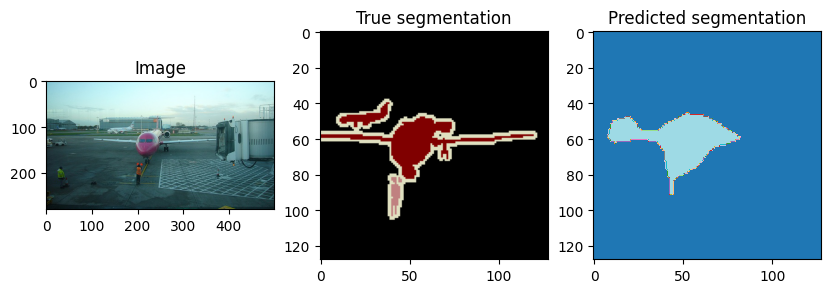

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
cmap = plt.cm.get_cmap('tab20', n_class + 1)
ax[0].imshow(img)
ax[0].set_title("Image")
ax[1].imshow(gt, cmap=cmap)
ax[1].set_title("True segmentation")
ax[2].imshow(pred[0], cmap=cmap)
ax[2].set_title("Predicted segmentation")
plt.show()

In [26]:
# Feel free to use the outputs of my code for the confidence calibration plot and ECE
# Here I run the model on all points in the validation set. 
# I collect predictions on all pixels, excluding masks, and flatten them. 

model.eval()
with torch.no_grad():
    all_acc = []
    all_conf = []
    for i, (inputs, labels) in enumerate(val_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)['out']
        labels = labels.squeeze(1).flatten(start_dim=1)  # batch, h, w  - integer values 0..20 or 255 for mask
        predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20  
        probs = outputs.softmax(axis=1)  # batch, n_class, h, w
        confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label
        accuracy = (predicted_label == labels)
        accuracy_filter = accuracy[labels < 255]
        confidence_filter = confidence[labels < 255]
        all_acc.append(accuracy_filter)
        all_conf.append(confidence_filter)
        
all_acc = torch.cat(all_acc).cpu().numpy()  # accuracy to predict pixel class across all pixels and images, excluding masks
all_conf = torch.cat(all_conf).cpu().numpy()  # confidence of prediction for each pixel and image, excluding masks
        
# Get the average confidence and accuracy for points within different confidence ranges
bins = 10
bin_boundaries = np.linspace(0, 1, bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_centers = 0.5*(bin_lowers+bin_uppers)
bin_acc = np.zeros(bins)  # Store accuracy within each bin
bin_conf = np.zeros(bins)  # Store confidence within each bin
bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin
for i in range(bins):
    in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])
    bin_frac[i] = np.sum(in_bin) / len(all_conf)  # fraction of points in bin
    if bin_frac[i] > 0.:
        bin_acc[i] = all_acc[in_bin].mean()  # average accuracy in this bin
        bin_conf[i] = all_conf[in_bin].mean()  # average confidence in this bin
    else:
        bin_acc[i], bin_conf[i] = 0, 0  # If no points are in this bin, they don't contribute to ECE anyway

ECE:  0.07716085917104815


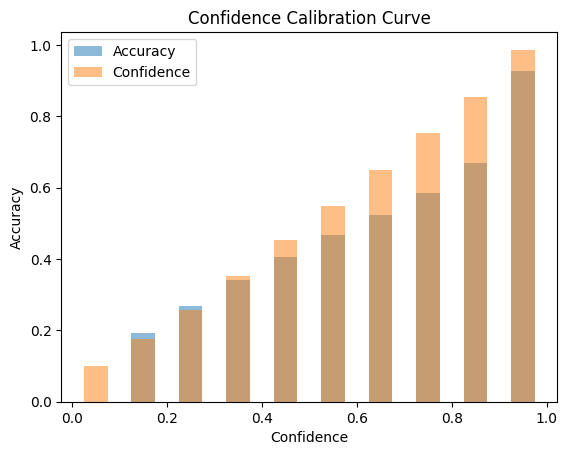

In [27]:
# TODO: Plot confidence calibration curve and calculate expected calibration error (1 point), using 
ece = np.sum(bin_frac*np.abs(bin_conf - bin_acc))
print("ECE: ", ece)

# TODO: confidence versus accuracy bar chart
plt.bar(bin_centers, bin_acc, width=0.05, label='Accuracy', alpha=0.5)
plt.bar(bin_centers, bin_conf, width=0.05, label='Confidence', alpha=0.5)
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Confidence Calibration Curve')
plt.legend()
plt.show()

### Extra Credits:
Exploring transfer learning strategies

In [33]:
batch_size = 128  # Adjust batch size to make maximal use of GPU without running out of memory 
epochs = 10
learning_rate = 0.001
n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored

# Load model and data
model = fcn_resnet50(n_class=n_class, pretrained=True).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)

# Training loop
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.)

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss, val_loss, accuracy = train_epoch(model, train_dl, val_dl, optimizer, device)
    
    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using downloaded and verified file: ./Downloads/VOCtrainval_06-Nov-2007.tar
Extracting ./Downloads/VOCtrainval_06-Nov-2007.tar to ./Downloads/
Using downloaded and verified file: ./Downloads/VOCtrainval_06-Nov-2007.tar
Extracting ./Downloads/VOCtrainval_06-Nov-2007.tar to ./Downloads/
Epoch 1: Train loss: 0.982 | Val loss: 0.344 | Acc: 0.894
Epoch 2: Train loss: 0.924 | Val loss: 0.370 | Acc: 0.891
Epoch 3: Train loss: 0.769 | Val loss: 0.392 | Acc: 0.889
Epoch 4: Train loss: 0.657 | Val loss: 0.408 | Acc: 0.887
Epoch 5: Train loss: 0.565 | Val loss: 0.421 | Acc: 0.885
Epoch 6: Train loss: 0.499 | Val loss: 0.431 | Acc: 0.883
Epoch 7: Train loss: 0.445 | Val loss: 0.441 | Acc: 0.880
Epoch 8: Train loss: 0.404 | Val loss: 0.448 | Acc: 0.877
Epoch 9: Train loss: 0.377 | Val loss: 0.455 | Acc: 0.875
Epoch 10: Train loss: 0.352 | Val loss: 0.463 | Acc: 0.873


In [34]:
img = Image.open(train_dl.dataset.images[0])
image_transforms = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
label_transforms = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128)])
with torch.no_grad():
    imtf= image_transforms(img).unsqueeze(0).to(device)
    pred = model(imtf)
    pred = pred["out"].max(1)[1].cpu().numpy()
gt = label_transforms(Image.open(train_dl.dataset.masks[0]))

<ipython-input-35-d961a01ff4f6>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', n_class + 1)


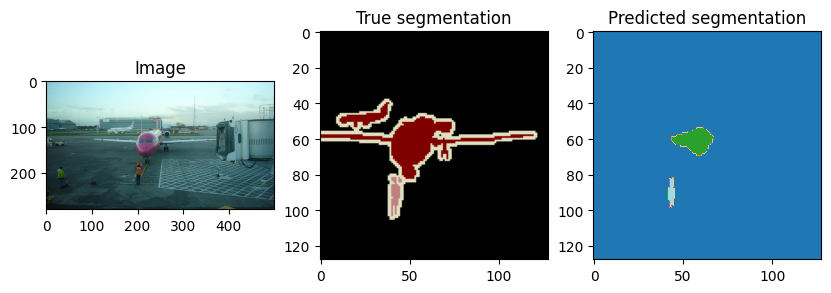

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
cmap = plt.cm.get_cmap('tab20', n_class + 1)
ax[0].imshow(img)
ax[0].set_title("Image")
ax[1].imshow(gt, cmap=cmap)
ax[1].set_title("True segmentation")
ax[2].imshow(pred[0], cmap=cmap)
ax[2].set_title("Predicted segmentation")
plt.show()

### Different data augmentation stratigies

Using imagenet normalize stats

In [30]:
def get_voc_dataloader(batch_size=4):
    """Get the VOC 2007 segmentation dataset and return PyTorch 
    dataloaders for both training and validation. 
    """
    # TODO: 2 points. Define image transforms for both the input image AND the "label" image.
    # Remember, the labels are one category (integer) per pixel. So, while the image_transform
    # normalize the values to have mean zero and unit standard deviation, you shouldn't 
    # do that with the labels, which have to be integers. I provided a "ToIntTensor" transform
    # above to use for the label transform, instead of ToTensor which always turns images to floats. 
    # Also, we want to resize/crop images to be all the same size, a power of 2, and 
    # we should transform the label and image in the same way when changing size.
    # The size of images will drastically impact memory usage - I suggest targeting 128 x 128 
    # or even 64 x 64 if memory constraints are an issue. 
    image_transforms = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    label_transforms = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128), ToIntTensor()])
    # This downloads the data automatically and creates a "dataset" object that applies the transforms
    data_dir = "./Downloads/"  # TODO: Specify path to save data
    train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True, transform=image_transforms, target_transform=label_transforms)
    val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True, transform=image_transforms, target_transform=label_transforms)

    # Create data loaders for the datasets - necessary for efficient training
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# Define some hyperparameters
batch_size = 64  # Adjust batch size to make maximal use of GPU without running out of memory 
epochs = 50
learning_rate = 0.01
n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored

# Load model and data
model = fcn_resnet50(n_class=n_class).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)
# Training loop
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.)

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss, val_loss, accuracy = train_epoch(model, train_dl, val_dl, optimizer, device)
    
    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy))

Using downloaded and verified file: ./Downloads/VOCtrainval_06-Nov-2007.tar
Extracting ./Downloads/VOCtrainval_06-Nov-2007.tar to ./Downloads/
Using downloaded and verified file: ./Downloads/VOCtrainval_06-Nov-2007.tar
Extracting ./Downloads/VOCtrainval_06-Nov-2007.tar to ./Downloads/
Epoch 1: Train loss: 2.333 | Val loss: 2.404 | Acc: 0.462
Epoch 2: Train loss: 1.079 | Val loss: 1.133 | Acc: 0.737
Epoch 3: Train loss: 0.851 | Val loss: 1.331 | Acc: 0.670
Epoch 4: Train loss: 0.675 | Val loss: 0.972 | Acc: 0.744
Epoch 5: Train loss: 0.524 | Val loss: 0.770 | Acc: 0.777
Epoch 6: Train loss: 0.445 | Val loss: 0.836 | Acc: 0.776
Epoch 7: Train loss: 0.416 | Val loss: 0.810 | Acc: 0.787
Epoch 8: Train loss: 0.355 | Val loss: 0.779 | Acc: 0.794
Epoch 9: Train loss: 0.323 | Val loss: 0.797 | Acc: 0.791
Epoch 10: Train loss: 0.288 | Val loss: 0.774 | Acc: 0.793
Epoch 11: Train loss: 0.287 | Val loss: 0.751 | Acc: 0.797
Epoch 12: Train loss: 0.274 | Val loss: 0.726 | Acc: 0.801
Epoch 13: Train

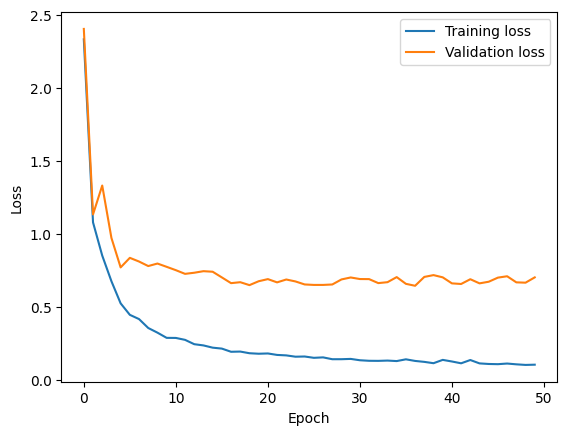

In [ ]:
# TODO: Train and test loss plot
# TODO: Print out an example image, true segmentation, and predicted segmentation
# 1 point
# Use a colormap to get good visualizations of the segmentation classes
# cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors
# cmap(numpy class array) outputs something with nice colors
plt.plot(range(len(train_losses)), train_losses, label="Training loss")
plt.plot(range(len(train_losses)), val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
img = Image.open(train_dl.dataset.images[0])
image_transforms = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
label_transforms = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128)])
with torch.no_grad():
    imtf= image_transforms(img).unsqueeze(0).to(device)
    pred = model(imtf)
    pred = pred["out"].max(1)[1].cpu().numpy()
gt = label_transforms(Image.open(train_dl.dataset.masks[0]))

<ipython-input-57-d961a01ff4f6>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', n_class + 1)


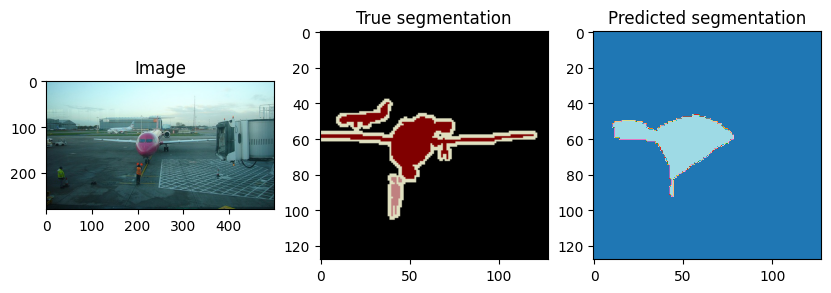

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
cmap = plt.cm.get_cmap('tab20', n_class + 1)
ax[0].imshow(img)
ax[0].set_title("Image")
ax[1].imshow(gt, cmap=cmap)
ax[1].set_title("True segmentation")
ax[2].imshow(pred[0], cmap=cmap)
ax[2].set_title("Predicted segmentation")
plt.show()

In [ ]:
# Feel free to use the outputs of my code for the confidence calibration plot and ECE
# Here I run the model on all points in the validation set. 
# I collect predictions on all pixels, excluding masks, and flatten them. 

model.eval()
with torch.no_grad():
    all_acc = []
    all_conf = []
    for i, (inputs, labels) in enumerate(val_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)['out']
        labels = labels.squeeze(1).flatten(start_dim=1)  # batch, h, w  - integer values 0..20 or 255 for mask
        predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20  
        probs = outputs.softmax(axis=1)  # batch, n_class, h, w
        confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label
        accuracy = (predicted_label == labels)
        accuracy_filter = accuracy[labels < 255]
        confidence_filter = confidence[labels < 255]
        all_acc.append(accuracy_filter)
        all_conf.append(confidence_filter)
        
all_acc = torch.cat(all_acc).cpu().numpy()  # accuracy to predict pixel class across all pixels and images, excluding masks
all_conf = torch.cat(all_conf).cpu().numpy()  # confidence of prediction for each pixel and image, excluding masks
        
# Get the average confidence and accuracy for points within different confidence ranges
bins = 10
bin_boundaries = np.linspace(0, 1, bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_centers = 0.5*(bin_lowers+bin_uppers)
bin_acc = np.zeros(bins)  # Store accuracy within each bin
bin_conf = np.zeros(bins)  # Store confidence within each bin
bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin
for i in range(bins):
    in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])
    bin_frac[i] = np.sum(in_bin) / len(all_conf)  # fraction of points in bin
    if bin_frac[i] > 0.:
        bin_acc[i] = all_acc[in_bin].mean()  # average accuracy in this bin
        bin_conf[i] = all_conf[in_bin].mean()  # average confidence in this bin
    else:
        bin_acc[i], bin_conf[i] = 0, 0  # If no points are in this bin, they don't contribute to ECE anyway

ECE:  0.08229446618460817


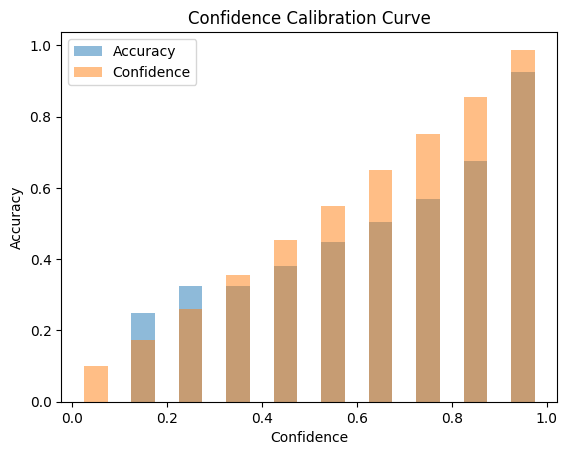

In [ ]:
# TODO: Plot confidence calibration curve and calculate expected calibration error (1 point), using 
ece = np.sum(bin_frac*np.abs(bin_conf - bin_acc))
print("ECE: ", ece)

# TODO: confidence versus accuracy bar chart
plt.bar(bin_centers, bin_acc, width=0.05, label='Accuracy', alpha=0.5)
plt.bar(bin_centers, bin_conf, width=0.05, label='Confidence', alpha=0.5)
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Confidence Calibration Curve')
plt.legend()
plt.show()